#Masker Model

Léo Dupire

##Load Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Projects/Collision-Prediction

Mounted at /content/gdrive
/content/gdrive/MyDrive/Projects/Collision-Prediction


In [2]:
import os
import random
import tqdm.auto as tqdm
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import imageio.v3 as iio
import matplotlib.pyplot as plt
from PIL import Image

## PyTorch
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

# Torchvision
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import ToTensor
import torchvision.transforms as T

In [3]:
#@title Import Tensor Data
# Train
imgs = torch.load('data/imgs.pt')
masks = torch.load('data/masks.pt')

# Validation
val_imgs = torch.load('data/val_imgs.pt')
val_masks = torch.load('data/val_masks.pt')

In [4]:
# SMALL_imgs = imgs[:8].clone()
# SMALL_masks = masks[:8].clone()
# SMALL_val_imgs = val_imgs[:8].clone()
# SMALL_val_masks = val_masks[:8].clone()

# torch.save(SMALL_imgs, 'data/SMALL_imgs.pt')
# torch.save(SMALL_masks, 'data/SMALL_masks.pt')

# torch.save(SMALL_val_imgs, 'data/SMALL_val_imgs.pt')
# torch.save(SMALL_val_masks, 'data/SMALL_val_masks.pt')

In [5]:
print(imgs.shape)
print(masks.shape)

torch.Size([1000, 22, 160, 240, 3])
torch.Size([1000, 22, 160, 240])


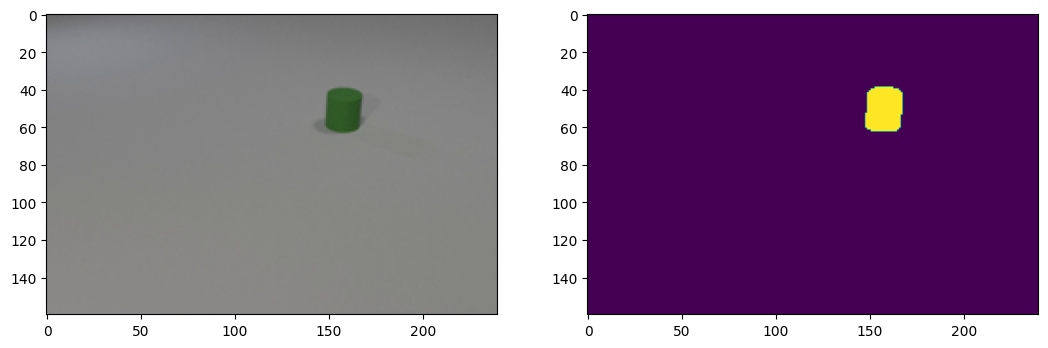

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))
axes[0].imshow(val_imgs[0][0])
axes[1].imshow(val_masks[0][0])
plt.show()

##Dataset Augmentation

In [7]:
#@title Dataset Class & Loaders
class MaskDataset(Dataset):
  def __init__(self, imgs, masks, transform=None):
    self.imgs = imgs.reshape(-1, 160, 240, 3)
    self.masks = masks.reshape(-1, 160, 240)
  
  def __len__(self):
    return len(self.masks)

  def __getitem__(self, index):
    img = self.imgs[index].to(torch.uint8)
    msk = self.masks[index]
    img = img.permute(2, 0, 1).to(torch.float) / 255
    img = (img - 0.5) / 2

    if random.random() > 0.5:
      img = torch.flip(img, dims=[2])
      msk = torch.flip(msk, dims=[1]) # Check this

    return (img, msk)

# Datasets
train_dataset = MaskDataset(imgs, masks,)
val_dataset = MaskDataset(val_imgs, val_masks,)

batch_size = 64

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [8]:
#@title Visualize (Comment out lines 13 & 14 of Dataset Class cell)
# example = next(iter(val_loader))
# image, mask = [x for x in example]

# fig, axes = plt.subplots(5, 2, figsize=(6.4*2, 5*4.8))
# for i in range(5):
#   axes[i][0].imshow(image[17+i])
#   axes[i][1].imshow(mask[17+i])
# plt.show()

##UNet

Code inspired by: https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [9]:
#@title Conv Block
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [10]:
#@title Encoder Block
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [11]:
#@title Decoder Block
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [12]:
#@title UNet Block
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 49, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

##Train

In [15]:
#@title Settings
latent_dim = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
#@title New Model
# model = UNet().to(device)
# input_tensor = train_dataset[0][0].unsqueeze(0).to(device)
# output = model(input_tensor)
# print(output.shape)

# result = {"train": [], "val": []} # For tracking loss
# best_val = -1 # Negative as real val will be positive

torch.Size([1, 49, 160, 240])


In [18]:
#@title Load a Model
model = UNet().to(device)
model.load_state_dict(torch.load("./masker_models/best_masker.pth"))
result = {"train": [], "val": []} # For tracking loss
best_val = -1 # Negative as real val will be positive

In [ ]:
summary(model, input_size=(3, 160, 240))

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

In [21]:
#@title Display Mask Output Comparison
def display_comp(model, index, ds="val", show_img=False):
  if ds == "val":
    example_image, example_mask = val_dataset[index]
  elif ds == "train":
    example_image, example_mask = train_dataset[index]

  pred_mask = model(example_image.unsqueeze(0).to(device)).cpu().squeeze(0)
  
  if show_img:
    example_image = (((example_image.permute(1, 2, 0)*2) + 0.5) * 255).to(int)

    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(example_image, vmin=0, vmax=48)
    axes[1].imshow(example_mask, vmin=0, vmax=48)
    axes[2].imshow(pred_mask.argmax(0), vmin=0, vmax=48)
  else:
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(example_mask, vmin=0, vmax=48)
    axes[1].imshow(pred_mask.argmax(0), vmin=0, vmax=48)
  plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/343 [00:00<?, ?it/s]

Epoch 1 | Train: 0.0032 | Val: 0.0053


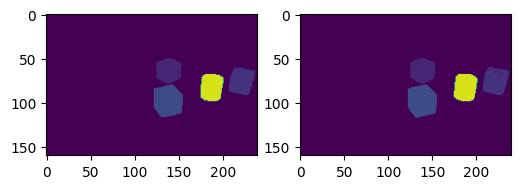

  0%|          | 0/343 [00:00<?, ?it/s]

Epoch 2 | Train: 0.0032 | Val: 0.0052


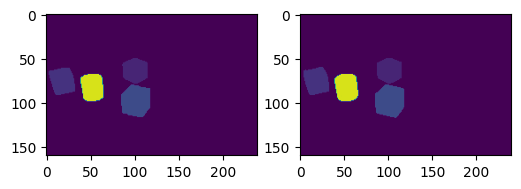

  0%|          | 0/343 [00:00<?, ?it/s]

Epoch 3 | Train: 0.0032 | Val: 0.0052


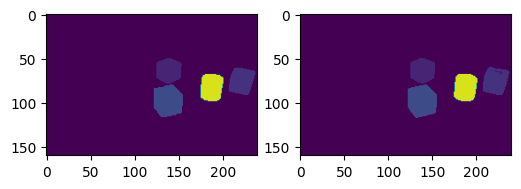

  0%|          | 0/343 [00:00<?, ?it/s]

Epoch 4 | Train: 0.0032 | Val: 0.0053


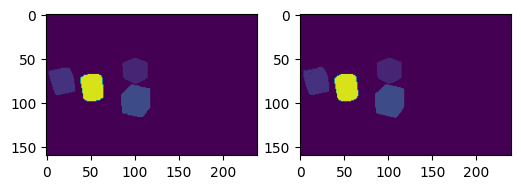

  0%|          | 0/343 [00:00<?, ?it/s]

Epoch 5 | Train: 0.0031 | Val: 0.0052


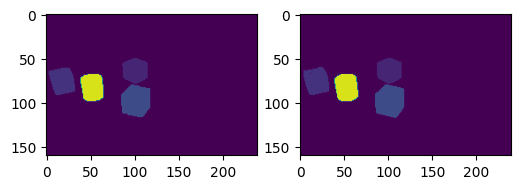

In [22]:
#@title Training
from tqdm.notebook import tqdm

num_epochs = 5

def get_loss(image, mask, optimizer=None):
  pred_mask = model(image)
  loss = criterion(pred_mask, mask.long())

  if optimizer is not None:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss

for epoch in tqdm(range(1, num_epochs+1), leave=False): # Train on several epochs
  total_train_loss = 0
  model.train()
  for batch in tqdm(train_loader, leave=False):
    image, mask = [x.to(device) for x in batch]
    total_train_loss += get_loss(image, mask, optimizer=optimizer)

  train_loss = total_train_loss.item() / len(train_loader)
  result["train"].append(train_loss)

  # Test best model on validation
  with torch.no_grad():
    val_result = 0
    count = 0
    model.eval()
    total_val_loss = 0
    for batch in val_loader:
      image, mask = [x.to(device) for x in batch]
      total_val_loss += get_loss(image, mask) * image.size(0)
      count += image.size(0)

    val_result = total_val_loss.item() / count
    result["val"].append(val_result)
    print(f"Epoch {epoch} | Train: {train_loss:.4f} | Val: {val_result:.4f}")

    if (best_val == -1) or (val_result < best_val):
        best_val = val_result
        torch.save(model.state_dict(), "./masker_models/best_masker.pth")

    display_comp(model, 40)
  scheduler.step(total_val_loss)

##Results

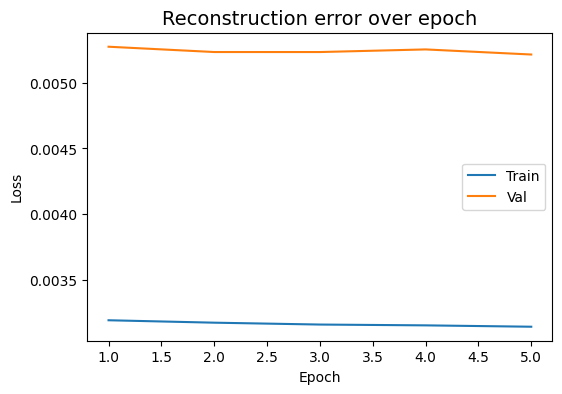

In [23]:
fig_prog = plt.figure(figsize=(6,4))

plt.plot(range(1, len(result["train"])+1), result["train"], label="Train")
plt.plot(range(1, len(result["val"])+1), result["val"], label="Val")
plt.title("Reconstruction error over epoch", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

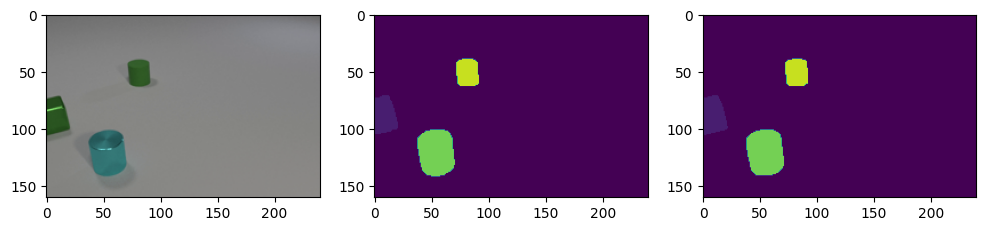

In [24]:
model.eval();
display_comp(model, 4, ds="val", show_img=True)